<a href="https://colab.research.google.com/github/Praj825/crypto-dashboard/blob/main/Time_series_for_crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
DEBUG:cmdstanpy:input tempfile: /tmp/tmpula98qlo/9dlim2c_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpula98qlo/lbtunpk5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73428', 'data', 'file=/tmp/tmpula98qlo/9dlim2c_.json', 'init=/tmp/tmpula98qlo/lbtunpk5.json', 'output', 'file=/tmp/tmpula98qlo/prophet_modeldv2l81lw/prophet_model-20250522163344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:33:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:33:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.0270
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0016
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0012
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0012
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0011
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0010
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 9.3622e-04
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 9.0663e-04
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 8.5298e-04
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 9.8855e-04


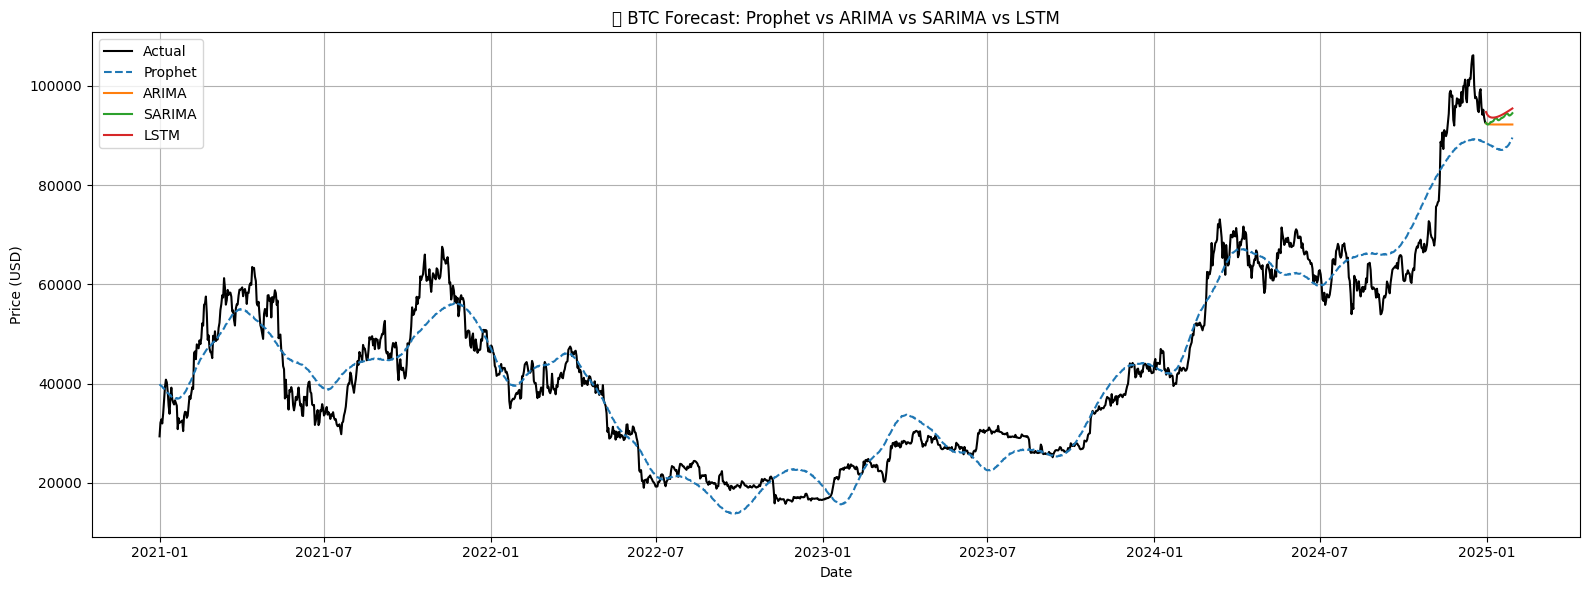

In [3]:
# 📦 Install dependencies
!pip install yfinance prophet statsmodels matplotlib pandas tensorflow keras

# 📚 Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

# 📈 Load BTC data
df = yf.download("BTC-USD", start="2021-01-01", end="2024-12-31")
df.reset_index(inplace=True)
df = df.loc[:, ["Date", "Close"]].dropna().copy()
df.columns = ["ds", "y"]                        # Rename columns directly
df["ds"] = pd.to_datetime(df["ds"])             # Ensure datetime
df["y"] = df["y"].astype(float)                 # Ensure float for Prophet

# ================================
# 🔮 PROPHET MODEL
# ================================
prophet_df = df[["ds", "y"]].copy()
prophet = Prophet(daily_seasonality=True)
prophet.fit(prophet_df)
future = prophet.make_future_dataframe(periods=30)
forecast_prophet = prophet.predict(future)

# ================================
# 🔁 ARIMA MODEL
# ================================
arima_model = ARIMA(df["y"], order=(5,1,0))
arima_fit = arima_model.fit()
forecast_arima = arima_fit.forecast(steps=30)

# ================================
# 🔁 SARIMA MODEL
# ================================
sarima_model = SARIMAX(df["y"], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit()
forecast_sarima = sarima_fit.forecast(steps=30)

# ================================
# 🧠 LSTM MODEL
# ================================
data = df[["y"]].values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

sequence_length = 60
x_train, y_train = [], []

for i in range(sequence_length, len(scaled_data)):
    x_train.append(scaled_data[i-sequence_length:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1)

test_input = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
lstm_predictions = []

for _ in range(30):
    next_price = model.predict(test_input, verbose=0)[0][0]
    lstm_predictions.append(next_price)
    next_seq = np.append(test_input[0][1:], [[next_price]], axis=0)
    test_input = next_seq.reshape(1, sequence_length, 1)

lstm_predictions = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1))
lstm_forecast_dates = df["ds"].iloc[-1] + pd.to_timedelta(np.arange(1, 31), unit='D')

# ================================
# 📊 FINAL PLOT
# ================================
plt.figure(figsize=(16,6))
plt.plot(df["ds"], df["y"], label="Actual", color="black")
plt.plot(forecast_prophet["ds"], forecast_prophet["yhat"], label="Prophet", linestyle="--")
plt.plot(df["ds"].iloc[-1] + pd.to_timedelta(range(1,31), unit="D"), forecast_arima, label="ARIMA")
plt.plot(df["ds"].iloc[-1] + pd.to_timedelta(range(1,31), unit="D"), forecast_sarima, label="SARIMA")
plt.plot(lstm_forecast_dates, lstm_predictions, label="LSTM")
plt.title("📈 BTC Forecast: Prophet vs ARIMA vs SARIMA vs LSTM")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
